In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
intervals = pd.DataFrame([[-259.1, -254.14], 
                          [-254.14, -251.902], 
                          [-251.902, -251], 
                          [-251, -250.4]], 
                         index=["Wuchiapingian",
                                "Changhsingian",
                                "Extinction",
                                "Griesbachian"], 
                         columns=["from", "to"])

In [3]:
intervals["mid"] = intervals.mean(axis=1)

In [4]:
intervals

,from,to,mid
Wuchiapingian,-259.100,-254.140,-256.620
Changhsingian,-254.140,-251.902,-253.021
Extinction,-251.902,-251.000,-251.451
Griesbachian,-251.000,-250.400,-250.700


In [5]:
def plot_auc(ax, model_name, color="r", show_range=False):
    
    auc_mean = [pd.read_csv(f"../results/{model_name}_TimeInterval{i}_AUC.csv", index_col=0).mean()[0] for i in range(1, 5)]
    auc_min = [pd.read_csv(f"../results/{model_name}_TimeInterval{i}_AUC.csv", index_col=0).min()[0] for i in range(1, 5)]
    auc_max = [pd.read_csv(f"../results/{model_name}_TimeInterval{i}_AUC.csv", index_col=0).max()[0] for i in range(1, 5)]
    
    if show_range:
        ax.fill_between(intervals.index, auc_min, auc_max, facecolor='lightgrey')
    
    if model_name == "CGB":
        long_name = "Categorical Gradient Boosting"
    elif model_name == "RFC":
        long_name = "Random Forest"
    if model_name == "LRC":
        long_name = "Logistic Regression"
        
    ax.plot(intervals.index, auc_mean, c=color, linestyle="-", marker="o", label=long_name)
    
    ax.set_ylim(0.5, 0.9)
    ax.set_ylabel("AUC")
    ax.grid(linestyle="--", alpha=0.5)
    
    ax.set_title(long_name)

In [8]:
%%capture
for model in ["CGB", "RFC", "LRC"]:
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plot_auc(ax, model, show_range=True)
    
    fig.savefig(f"../results/figures/{model}_AUC.png", bbox_inches="tight", dpi=300)

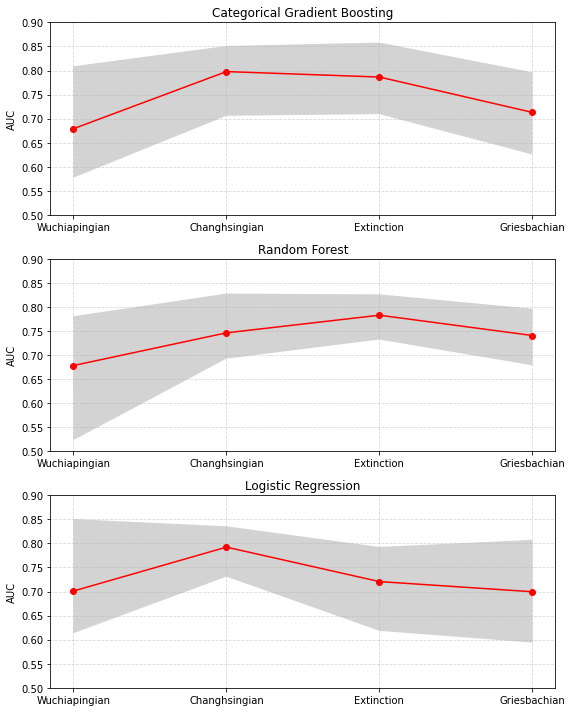

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

for i, model in enumerate(["CGB", "RFC", "LRC"]):
    plot_auc(axes[i], model, show_range=True)

fig.tight_layout()

fig.savefig("../results/figures/ALL_AUC.png", bbox_inches="tight", dpi=300)

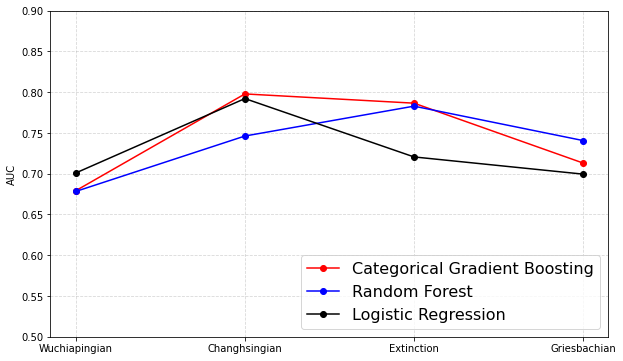

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

for model, color in zip(["CGB", "RFC", "LRC"], ["r", "b", "k"]):
    plot_auc(ax, model, color, show_range=False)

ax.legend(fontsize=16, loc="lower right")
ax.set_title("")
    
fig.savefig("../results/figures/ALL_AUC_2.png", bbox_inches="tight", dpi=300)

In [11]:
def plot_importances(ax, model_name):
    
    fi = pd.concat([pd.read_csv(f"../results/{model_name}_TimeInterval{i}_FI.csv", index_col=0).mean() for i in range(1, 5)], axis=1)
    fi.columns = intervals.index
    
    if model_name == "CGB":
        long_name = "Categorical Gradient Boosting"
        cmap = "Reds"
        cbar_label = 'relative importance, %'
    elif model_name == "RFC":
        long_name = "Random Forest"
        cmap = "Reds"
        cbar_label = 'relative importance, %'
    if model_name == "LRC":
        long_name = "Logistic Regression"
        cmap = "RdBu_r"
        cbar_label = 'feature coefficients'
    
    
    sns.heatmap(fi, cmap=cmap, ax=ax, annot=True, cbar_kws={'label': cbar_label})
    
    ax.set_title(long_name)

In [12]:
%%capture
for model in ["CGB", "RFC", "LRC"]:
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    plot_importances(ax, model)
    
    fig.savefig(f"../results/figures/{model}_FI.png", bbox_inches="tight", dpi=300)

In [13]:
def plot_roc_curves(axes, model_name):
    
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

    for i, interval in enumerate(intervals.index):

        roc_curves = np.load(f"../results/{model_name}_TimeInterval{i+1}_RC.npy", allow_pickle=True).item()

        for split, color in zip(roc_curves.keys(), colors):

            axes[i].plot([0,1], [0,1], "k--", zorder=0)
            axes[i].plot(roc_curves[split]["FPR"], 
                         roc_curves[split]["TPR"], 
                         label=f"{split} (AUC={np.round(auc(roc_curves[split]['FPR'],roc_curves[split]['TPR']),2)})", 
                         linestyle="-", 
                         color=color)

            axes[i].set_xlim(0,1)
            axes[i].set_ylim(0,1.05)

            axes[i].set_xlabel("False Positive Rate")
            axes[i].set_ylabel("True Positive Rate")

            axes[i].set_title(interval)
            axes[i].legend()

In [14]:
%%capture
for model in ["CGB", "RFC", "LRC"]:
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.ravel()
    
    plot_roc_curves(axes, model)
    
    fig.tight_layout()
    
    fig.savefig(f"../results/figures/{model}_RC.png", bbox_inches="tight", dpi=300)

In [15]:
def plot_confusion_matrices(axes, model_name):
    for i, interval in enumerate(intervals.index):

        cv_true_pred = np.load(f"../results/{model_name}_TimeInterval{i+1}_TP.npy", allow_pickle=True).item()

        targets = np.concatenate([x['true'] for x in cv_true_pred.values()])
        preds = np.concatenate([x['pred'] for x in cv_true_pred.values()])
        
        cm = confusion_matrix(targets, preds > 0.5)
        disp = ConfusionMatrixDisplay(cm, display_labels=['Not extinct', 'Extinct'])
        disp.plot(ax=axes[i])
        axes[i].set_title(interval)
        
        print(roc_auc_score(targets, preds))

In [16]:
%%capture
for model in ["CGB", "RFC", "LRC"]:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    axes = axes.ravel()

    plot_confusion_matrices(axes, model)

    fig.tight_layout()
    
    fig.savefig(f"../results/figures/{model}_CM.png", bbox_inches="tight", dpi=300)